# HP Grid Search

In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 150

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from deton8.utils import NucleiDataset
from deton8.processing import Preprocesser

In [5]:
train = NucleiDataset("../data/stage1_train/").load()

664image [02:44,  4.05image/s]


In [8]:
validation = NucleiDataset("../data/stage1_test").load()

65image [00:01, 42.65image/s]


In [6]:
from deton8.processing import Preprocesser

In [7]:
preprocesser = Preprocesser()
processed = preprocesser.fit_transform(train.images_)

In [10]:
val_processed = preprocesser.transform(validation.images_)

In [9]:
from deton8.features import BasisTransformer

In [13]:
transformer = BasisTransformer()
x_train_feat = transformer.fit_transform(processed)
x_val_feat = transformer.fit_transform(val_processed)

100%|██████████| 65/65 [00:01<00:00, 34.62pair/s]


In [14]:
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor

In [19]:
j

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [63]:
grid_sgd = {
    "regressor": [SGDRegressor(penalty='elasticnet')],
    "regressor__l1_ratio": np.linspace(0.1, 0.9, 3),
    "regressor__alpha": np.logspace(-4, 2, 6),
    "batch_size": [1000],
    "num_iters": [2500]
}

grid_pa = {
    "regressor": [PassiveAggressiveRegressor()],
    "regressor__C": np.logspace(-3, 4, 7),
    "batch_size": [1000],
    "num_iters": [2500],
}

In [55]:
from deton8.models import MiniBatchRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

sgd = MiniBatchRegressor()
pa = MiniBatchRegressor(regressor=PassiveAggressiveRegressor())

In [40]:
im_auc_score = lambda y_true, y_pred: roc_auc_score(y_true.flatten(), y_pred.flatten())

In [64]:
gs = GridSearchCV(estimator=sgd, param_grid=grid_sgd, scoring=make_scorer(im_auc_score), n_jobs=1, cv=2, return_train_score=True, verbose=2)
gs.fit(train.images_, (train.masks_ > 0).astype(np.int16))

In [76]:
cv_results = pd.DataFrame(gs.cv_results_)
sgd_results = cv_results[["mean_test_score", "mean_train_score", "param_regressor__l1_ratio", "param_regressor__alpha"]]
sgd_results = sgd_results.rename(columns={"mean_test_score": "test roc auc", "mean_train_score": "train roc auc", "param_regressor__l1_ratio": "l1 ratio", "param_regressor__alpha": "alpha"})
with open("../paper/sgd-gridsearch-table.tex", "w") as gs_file:
    gs_file.write(sgd_results.to_latex(index=False))
sgd_results

,test roc auc,train roc auc,l1 ratio,alpha
0,0.876541,0.876653,0.1,0.0001
1,0.877302,0.877200,0.5,0.0001
2,0.877345,0.877240,0.9,0.0001
3,0.877265,0.877211,0.1,0.00158489
4,0.877272,0.877222,0.5,0.00158489
5,0.877256,0.877197,0.9,0.00158489
6,0.877260,0.877212,0.1,0.0251189
7,0.877245,0.877201,0.5,0.0251189
8,0.877282,0.877230,0.9,0.0251189
9,0.877257,0.877224,0.1,0.398107


In [65]:
gs_pa = GridSearchCV(estimator=pa, param_grid=grid_pa, scoring=make_scorer(im_auc_score), n_jobs=1, cv=2, return_train_score=True, verbose=1)
gs_pa.fit(train.images_, (train.masks_ > 0).astype(np.int16))

In [78]:
cv_results = pd.DataFrame(gs_pa.cv_results_)
pa_results = cv_results[["mean_test_score", "mean_train_score", "param_regressor__C"]]
pa_results = pa_results.rename(columns={"mean_test_score": "test roc auc", "mean_train_score": "train roc auc", "param_regressor__C": "C"})
with open("../paper/pa-gridsearch-table.tex", "w") as gs_file:
    gs_file.write(pa_results.to_latex(index=False))

In [79]:
pa_results

,test roc auc,train roc auc,C
0,0.791785,0.794468,0.001
1,0.738755,0.744501,0.014678
2,0.870130,0.871063,0.215443
3,0.865080,0.868671,3.16228
4,0.452432,0.421358,46.4159
5,0.844023,0.837040,681.292
6,0.821930,0.829922,10000


### train

In [72]:
from deton8.models import UNet
from keras.callbacks import ModelCheckpoint

In [73]:
chkpt = ModelCheckpoint(
    filepath="../weights/unet_weights.h5", 
    save_weights_only=True, 
    save_best_only=True,
    period=5)
steps_per_epoch = 25
epochs = 50
unet = UNet(numchannels=8, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[chkpt])

Tensor("conv2d_9_target:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("conv2d_9/Sigmoid:0", shape=(?, 256, 256, 1), dtype=float32)


In [75]:
unet.load_weights("../weights/unet_weights.h5")

Successfully loaded weights from ../weights/unet_weights.h5...


In [ ]:
unet.predict()

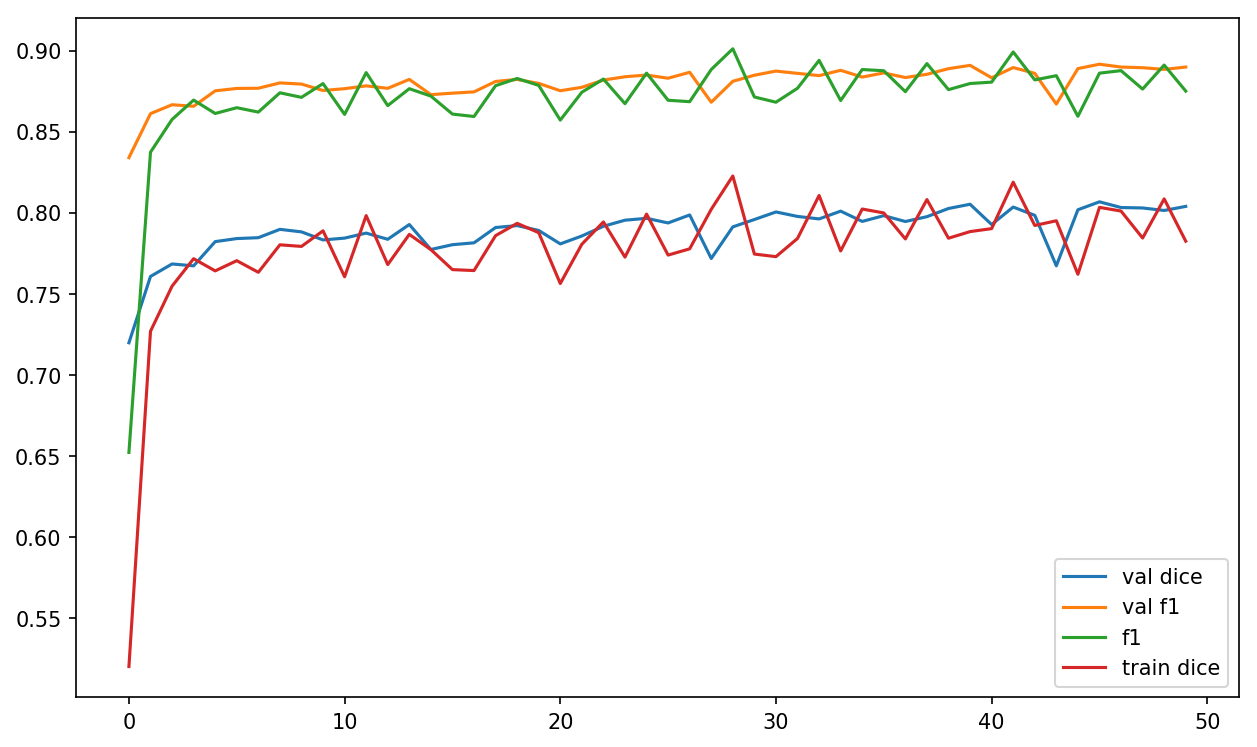

In [119]:
plt.plot(unet.model.history.history['val_dice_coef'], label = 'val dice')
plt.plot(unet.model.history.history['val_f1'], label = 'val f1')
plt.plot(unet.model.history.history['f1'], label = 'f1')
plt.plot(unet.model.history.history['dice_coef'], label = 'train dice')
plt.legend()